In [1]:
import os
import sys
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.galerkin import DGMNet
from branch.branch import Net

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## PDE solver using dolfinx

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
# import tqdm.notebook

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc
from dolfinx.fem.petsc import apply_lifting, assemble_matrix, assemble_vector, create_vector, set_bc
from dolfinx.graph import create_adjacencylist
from dolfinx.geometry import BoundingBoxTree, compute_collisions, compute_colliding_cells
from dolfinx.io import (XDMFFile, cell_perm_gmsh, distribute_entity_data, extract_gmsh_geometry,
                        extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh)
from dolfinx.mesh import create_mesh, meshtags_from_entities

from ufl import (FacetNormal, FiniteElement, Identity, Measure, TestFunction, TrialFunction, VectorElement,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym)

gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y =0.2
r = 0.05
gdim = 2
rank = MPI.COMM_WORLD.rank
if rank == 0:
    rectangle = gmsh.model.occ.addRectangle(0,0,0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)
    
if rank == 0:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()
    
fluid_marker = 1
if rank == 0:
    volumes = gmsh.model.getEntities(dim=gdim)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")
    
inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if rank == 0:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H/2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H/2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L/2, H, 0]) or np.allclose(center_of_mass, [L/2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax
res_min = r / 3.7
res_max = 1.5 * r
if rank == 0:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", obstacle)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(2, "LcMax", res_max)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4*r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 8*r)

    # We take the minimum of the two fields as the mesh size
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)
    
if rank == 0:
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 8)
    gmsh.option.setNumber("Mesh.RecombineAll", 2)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")
    
if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

    # Sort elements by ascending dimension
    perm_sort = np.argsort(cell_dimensions)

    # Broadcast cell type data and geometric dimension
    cell_id = cell_information[perm_sort[-1]]["id"]
    tdim = cell_information[perm_sort[-1]]["dim"]
    num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)
    if tdim - 1 in cell_dimensions:
        num_facet_nodes = MPI.COMM_WORLD.bcast( cell_information[perm_sort[-2]]["num_nodes"], root=0)
        gmsh_facet_id = cell_information[perm_sort[-2]]["id"]
        marked_facets = np.asarray(topologies[gmsh_facet_id]["topology"], dtype=np.int64)
        facet_values = np.asarray(topologies[gmsh_facet_id]["cell_data"], dtype=np.int32)

    cells = np.asarray(topologies[cell_id]["topology"], dtype=np.int64)
    cell_values = np.asarray(topologies[cell_id]["cell_data"], dtype=np.int32)

else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = np.empty([0, num_nodes], np.int64), np.empty([0, gdim])
    cell_values = np.empty((0,), dtype=np.int32)
    num_facet_nodes = MPI.COMM_WORLD.bcast(None, root=0)
    marked_facets = np.empty((0, num_facet_nodes), dtype=np.int64)
    facet_values = np.empty((0,), dtype=np.int32)

# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = cell_perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim
fdim = tdim - 1
# Permute facets from MSH to DOLFINx ordering
# FIXME: Last argument is 0 as all facets are the same for tetrahedra
facet_type = cell_entity_type(to_type(str(ufl_domain.ufl_cell())), fdim, 0)
gmsh_facet_perm = cell_perm_gmsh(facet_type, num_facet_nodes)
marked_facets = np.asarray(marked_facets[:, gmsh_facet_perm], dtype=np.int64)

local_entities, local_values = distribute_entity_data(mesh, fdim, marked_facets, facet_values)
mesh.topology.create_connectivity(fdim, tdim)
adj = create_adjacencylist(local_entities)
# Create DOLFINx MeshTags
ft = meshtags_from_entities(mesh, fdim, adj, np.int32(local_values))
ft.name = "Facet tags"

t = 0
T = 1 #8                    # Final time
dt = 1/1600                 # Time step size
num_steps = int(T/dt)
k = Constant(mesh, PETSc.ScalarType(dt))        
mu = Constant(mesh, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(mesh, PETSc.ScalarType(1))     # Density

v_cg2 = VectorElement("CG", mesh.ufl_cell(), 2)
s_cg1 = FiniteElement("CG", mesh.ufl_cell(), 1)
V = FunctionSpace(mesh, v_cg2)
Q = FunctionSpace(mesh, s_cg1)

fdim = mesh.topology.dim - 1

# Define boundary conditions
class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi/8) * x[1] * (0.41 - x[1])/(0.41**2)
        return values

# Inlet
u_inlet = Function(V)
inlet_velocity = InletVelocity(t)
u_inlet.interpolate(inlet_velocity)
inlet_facets = ft.indices[ft.values == inlet_marker]

bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(V, fdim, inlet_facets))
# Walls
u_nonslip = np.array((0,) *mesh.geometry.dim, dtype=PETSc.ScalarType)
wall_facets = ft.indices[ft.values == wall_marker]
bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, wall_facets), V)
# Obstacle
obstacle_facets = ft.indices[ft.values == obstacle_marker]
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, obstacle_facets), V)
bcu = [bcu_inflow, bcu_obstacle, bcu_walls]
# Outlet
outlet_facets = ft.indices[ft.values == outlet_marker]
bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, outlet_facets), Q)
bcp = [bcp_outlet]

u = TrialFunction(V)
v = TestFunction(V)
u_ = Function(V)
u_.name = "u"
u_s = Function(V)
u_n = Function(V)
u_n1 = Function(V)
p = TrialFunction(Q)
q = TestFunction(Q)
p_ = Function(Q)
p_.name = "p"
phi = Function(Q)

f = Constant(mesh, PETSc.ScalarType((0,0)))
F1 = rho / k * dot(u - u_n, v) * dx 
F1 += inner(1.5 * dot(u_n, nabla_grad(u_n)) - 0.5 * dot(u_n1, nabla_grad(u_n1)), v) * dx
F1 += 0.5 * mu * inner(grad(u+u_n), grad(v))*dx - dot(p_, div(v))*dx
F1 += dot(f, v) * dx
a1 = form(lhs(F1))
L1 = form(rhs(F1))
A1 = assemble_matrix(a1, bcs=bcu)
A1.assemble()
b1 = create_vector(L1)

a2 = form(dot(grad(p), grad(q))*dx)
L2 = form(-1/k * dot(div(u_s), q) * dx)
A2 = assemble_matrix(a2, bcs=bcp)
A2.assemble()
b2 = create_vector(L2)

a3 = form(dot(u, v)*dx)
L3 = form(dot(u_s, v)*dx - k * dot(nabla_grad(phi), v)*dx)
A3 = assemble_matrix(a3)
A3.assemble()
b3 = create_vector(L3)

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A1)
solver1.setType(PETSc.KSP.Type.BCGS)
pc1 = solver1.getPC()
pc1.setType(PETSc.PC.Type.JACOBI)

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm)
solver2.setOperators(A2)
solver2.setType(PETSc.KSP.Type.MINRES)
pc2 = solver2.getPC()
pc2.setType(PETSc.PC.Type.HYPRE)
pc2.setHYPREType("boomeramg")

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm)
solver3.setOperators(A3)
solver3.setType(PETSc.KSP.Type.CG)
pc3 = solver3.getPC()
pc3.setType(PETSc.PC.Type.SOR)

n = -FacetNormal(mesh) # Normal pointing out of obstacle
dObs = Measure("ds", domain=mesh, subdomain_data=ft, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u_)
drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] - p_ * n[0]) * dObs)
lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] + p_ * n[1]) * dObs)
if rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    t_u = np.zeros(num_steps, dtype=np.float64)
    t_p = np.zeros(num_steps, dtype=np.float64)
    
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
points = np.array([[0.15, 0.2, 0], [0.25, 0.2, 0]])
cell_candidates = compute_collisions(tree, points)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, points)
front_cells = colliding_cells.links(0)
back_cells = colliding_cells.links(1)
if rank == 0:
    p_diff = np.zeros(num_steps, dtype=PETSc.ScalarType)
    
xdmf = XDMFFile(MPI.COMM_WORLD, "dfg2D-3.xdmf", "w")
xdmf.write_mesh(mesh)
xdmf.write_function(u_, t)
xdmf.write_function(p_, t)

# progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)
# If running this as a python script, you should use the Progressbar command below
# progress = tqdm.tqdm(desc="Solving PDE", total=num_steps)
for i in range(num_steps):
    # progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc:
        loc.set(0)
    assemble_vector(b1, L1)
    apply_lifting(b1, [a1], [bcu])
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b1, bcu)
    solver1.solve(b1, u_s.vector)
    u_s.x.scatter_forward()

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc:
        loc.set(0)
    assemble_vector(b2, L2)
    apply_lifting(b2, [a2], [bcp])
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b2, bcp)
    solver2.solve(b2, phi.vector)
    phi.x.scatter_forward()

    p_.vector.axpy(1, phi.vector)
    p_.x.scatter_forward()

    # Step 3: Velocity correction step
    with b3.localForm() as loc:
        loc.set(0)
    assemble_vector(b3, L3)
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    solver3.solve(b3, u_.vector)
    u_.x.scatter_forward()

    # Write solutions to file
    xdmf.write_function(u_, t)
    xdmf.write_function(p_, t)

    # Update variable with solution form this time step
    with u_.vector.localForm() as loc_, u_n.vector.localForm() as loc_n, u_n1.vector.localForm() as loc_n1:
        loc_n.copy(loc_n1)
        loc_.copy(loc_n)

    # Compute physical quantities
    # For this to work in paralell, we gather contributions from all processors
    # to processor zero and sum the contributions. 
    drag_coeff = MPI.COMM_WORLD.gather(assemble_scalar(drag), root=0)
    lift_coeff = MPI.COMM_WORLD.gather(assemble_scalar(lift), root=0)
    p_front = None
    if len(front_cells) > 0:
        p_front = p_.eval(points[0], front_cells[:1])
    p_front = MPI.COMM_WORLD.gather(p_front, root=0)
    p_back = None
    if len(back_cells) > 0:
        p_back = p_.eval(points[1], back_cells[:1])
    p_back = MPI.COMM_WORLD.gather(p_back, root=0)
    if rank == 0:
        t_u[i] = t
        t_p[i] = t-dt/2
        C_D[i] = sum(drag_coeff)
        C_L[i] = sum(lift_coeff)
        # Choose first pressure that is found from the different processors
        for pressure in p_front:
            if pressure is not None:
                p_diff[i] = pressure[0]
                break
        for pressure in p_back:
            if pressure is not None:
                p_diff[i] -= pressure[0]
                break
# Close xmdf file
xdmf.close()
print("Simulation done!")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Ellipse)
Info    : Done meshing 1D (Wall 0.0078379s, CPU 0.004714s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Simple recombination completed (Wall 0.0182901s, CPU 0.017878s): 1180 quads, 354 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.773076, min Q = 0.435836
Info    : Done meshing 2D (Wall 0.0474852s, CPU 0.045689s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info    : [ 50%] Meshing curve 4 order 2
Info    : [ 70%] Meshing curve 5 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 0.845684 (0 elements in ]0, 0.2]); wo

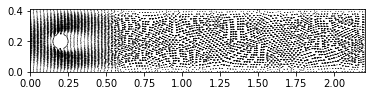

In [2]:
from dolfinx.plot import create_vtk_mesh
from scipy import spatial
import pyvista
cells, types, x = create_vtk_mesh(V)
tree = spatial.KDTree(x[:, :2])

# smaller subset of x
nb_points = 100
x1, x2 = np.meshgrid(
        np.linspace(0, L, nb_points),
        np.linspace(0, H, nb_points)
)
# get the nearest point
val, idx = tree.query(np.stack((x1, x2)).reshape(2, -1).T)

u_tmp = u_.x.array.reshape(x.shape[0], V.dofmap.index_map_bs)
u1, u2 = u_tmp[idx, 0], u_tmp[idx, 1]
x1, x2 = x[idx, 0], x[idx, 1]

plt.xlim(0, L)
plt.ylim(0, H)
plt.axis('scaled')
plt.quiver(x1, x2, u1, u2)
plt.savefig("quiver.png", dpi=300)

# Implementation with closed-form formula given by Borodin

In [2]:
lower_bound, upper_bound = -10, 10

def conditional_probability_to_survive(t, x, y, k_arr=range(-5, 5)):
    ans = 0
    for k in k_arr:
        ans += (
                torch.exp(((y - x) ** 2 - (y - x + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
                - torch.exp(((y - x) ** 2 - (y + x - 2 * lower_bound + 2 * k * (upper_bound - lower_bound)) ** 2) / (2 * t))
        )
    return ans.prod(dim=0)

def is_x_inside(x):
    return torch.logical_and(lower_bound <= x, x <= upper_bound).all(dim=0)

## Example 1: heat equation

The heat equation
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega,
\end{cases}
$$
where
$A = [a, b]$
and
$\Omega = [\text{lo}, \text{hi}]$,
admits the closed-form solution of
\begin{align*}
u_A(t, x) = 
\sum\limits_{k=-\infty}^\infty
& \Phi\left(\frac{b - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
\\
& - \Phi\left(\frac{b + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right)
+ \Phi\left(\frac{a + x - 2\text{lo} + 2k(\text{hi}-\text{lo})}{\sqrt{\nu(T-t)}}\right).
\end{align*}
On the other hand, when $\text{hi} \to \infty$ and $\text{lo} \to -\infty$, the solution is given by
$$
u_A(t, x) = 
\Phi\left(\frac{b - x}{\sqrt{\nu(T-t)}}\right)
- \Phi\left(\frac{a - x}{\sqrt{\nu(T-t)}}\right).
$$

In [7]:
nu = 1
y, eps = 0, 1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([0]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return torch.zeros_like(y[0])

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

def exact_example(t, x, T, with_bound=False, k_arr=range(-5, 5)):
    if t == T:
        return np.logical_and(x[0] <= b, x[0] >= a)
    else:
        normal_std = math.sqrt(nu * (T - t))
        if not with_bound:
            # without bound
            return norm.cdf((b - x[0]) / normal_std) - norm.cdf((a - x[0]) / normal_std)
        else:
            # with bound
            ans = 0
            for k in k_arr:
                mu = x[0] - 2 * k * (upper_bound - lower_bound)
                ans += (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
                mu = 2 * lower_bound - 2 * k * (upper_bound - lower_bound) - x[0]
                ans -= (norm.cdf((b - mu) / normal_std) - norm.cdf((a - mu) / normal_std))
            return ans

t_lo, x_lo, x_hi, n = 0., lower_bound, upper_bound, 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

patches = 10
T = patches * 1.0
true = exact_example(t_lo, grid_d_dim, T)
true_with_bound = exact_example(t_lo, grid_d_dim, T, with_bound=True)
terminal = exact_example(T, grid_d_dim, T)

In [ ]:
torch.manual_seed(0)

# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
# plt.plot(grid, true, label="True solution without bound")
plt.plot(grid, true_with_bound, label="True solution with bound")
plt.legend()
plt.show()

## Example 2: Kuramoto equation 1

### patches = 10, T = 1.0

In [33]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        15
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 10
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

In [ ]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=100,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.plot(grid, terminal, label="Terminal condition")
plt.legend()
plt.show()

### patches = 2, T = .2

In [31]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T):
    theta = -.5 * x[0] - (T - t)
    return (
        15
        + 15 * np.tanh(theta)
        - 15 * (np.tanh(theta))**2
        - 15 * (np.tanh(theta))**3
    )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 2
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

In [ ]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=50,
    branch_activation="softplus",
    layers=6,
    neurons=50,
    branch_lr=1e-3,
    lr_gamma=.8,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.plot(grid, terminal, label="Terminal condition")
plt.legend()
plt.show()

### patches = 1, T = .1

In [24]:
alpha, beta, gamma = 1, 4, 1

# function definition
deriv_map = np.array([0, 1, 3, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> third deriv
    idx 3 -> forth deriv
    """
    return (y[0] - 4) * y[1] + beta * y[2] + gamma * y[3]

def phi_example(x):
    theta = -.5 * x[0]
    return (
        15
        + 15 * torch.tanh(theta)
        - 15 * (torch.tanh(theta))**2
        - 15 * (torch.tanh(theta))**3
    )

def exact_example(t, x, T, order=(0, 0)):
    theta = -.5 * x[0] - (T - t)
    if order[1] == 0:
        return (
            15
            + 15 * np.tanh(theta)
            - 15 * (np.tanh(theta))**2
            - 15 * (np.tanh(theta))**3
        )
    elif order[1] == 1:
        return -.5 / (np.cosh(theta))**2 * (
            15
            - 30 * np.tanh(theta)
            - 45 * (np.tanh(theta))**2
        )
    elif order[1] == 2:
        return (
            - .5 / (np.cosh(theta))**4 * (
                15 + 45 * np.tanh(theta)
            )
            - .5 * np.tanh(theta) / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 3:
        return (
            11.25 / (np.cosh(theta))**6
            + .25 / (np.cosh(theta))**4 * (
                15 - 120 * np.tanh(theta) - 315 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**2 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )
    elif order[1] == 4:
        return (
            1 / (np.cosh(theta))**6 * (
                15 + 112.5 * np.tanh(theta)
            )
            + .5 * np.tanh(theta) / (np.cosh(theta))**4 * (
                30 - 165 * np.tanh(theta) - 405 * (np.tanh(theta))**2
            )
            - .5 * (np.tanh(theta))**3 / (np.cosh(theta))**2 * (
                15
                - 30 * np.tanh(theta)
                - 45 * (np.tanh(theta))**2
            )
        )

t_lo, x_lo, x_hi = 0., lower_bound, upper_bound
grid = np.linspace(x_lo, x_hi, 1000)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 1000)), grid_d_dim), axis=0)

patches = 1
T = patches * .1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

In [ ]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    outlier_multiplier=50,
    branch_activation="softplus",
    layers=6,
    neurons=50,
    branch_lr=1e-3,
    lr_gamma=.8,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
for order in ((0, 0), (0, 1), (0, 2), (0, 3), (0, 4)):
    true = exact_example(t_lo, grid_d_dim, T, order=order)
    x = torch.tensor(grid_d_dim_with_t.astype(np.float32), device=model.device, requires_grad=True)
    y =  model(x.T, patch=patches-1)
    deriv = model.nth_derivatives(order, y, x)
    plt.plot(grid, deriv.detach().cpu(), label="NN approximation")
    plt.plot(grid, true, label="True solution")
    plt.title(f"Derivatives comparison of order {order[1]}")
    plt.legend()
    plt.show()

## Example 3: Kuramoto equation 5

In [18]:
alpha, gamma = 1, 1

# function definition
deriv_map = np.array([0, 1, 4]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> forth deriv
    """
    return y[0] * y[1] + gamma * y[2]

def phi_example(x):
    return torch.exp(-x[0]**2)

t_lo, x_lo, x_hi = 0., -10., 10.
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

patches = 10
T = patches * .1

In [ ]:
# define NN and train
model = Net(
    f_fun=f_example,
    deriv_map=deriv_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=conditional_probability_to_survive,
    is_x_inside=is_x_inside,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=2*alpha,
    branch_patches=patches,
    branch_nb_path_per_state=10000,
)
model.train_and_eval(debug_mode=True)

# plot NN solution for comparison
nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device), patch=patches-1)
        .detach()
        .cpu()
        .numpy()
)
plt.plot(grid, nn, label="NN approximation")
plt.legend()
plt.show()

# Implementation with DGM

We are interested in the following quantity
$$
p(T, x, y) = \mathbb{P}_x(X_t \in \Omega \text{ for all } t \le T | X_T=y),
$$
where $\Omega \subset \mathbb{R}^d$.
Such term can be approximated by
$p(T, x, y) \approx \frac{\mathbb{P}_x(X_T \in A \ \text{ and } \ X_t \in \Omega \text{ for all } t \le T)}{\mathbb{P}_x(X_T \in A)} = \frac{u_A(0, x)}{\mathbb{P}_x(X_T \in A)}$,
where $A$ is a small neighborhood containing $y$
and $u_A$ satisfies the following PDE:
$$
\begin{cases}
& \partial_t u_A(t, x) + \frac{\nu}{2}\Delta u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \Omega,
\\
& u_A(T, x) = 1_{x \in A}, \qquad \text{for all } x \in \Omega,
\\
& u_A(t, x) = 0, \qquad \text{for all } (t, x) \in [0, T] \times \partial\Omega.
\end{cases}
$$

For simplicity, we first deal with the case $\nu=1$, $d=1$, $\Omega = (\infty, 2]$, $x = 0$, $y = 1$, $A = [1 - \epsilon, 1 + \epsilon]$.

In this case, $p(T, x, y)$ is known explicitly as
$$
p(T, x, y) = 1 - \exp\left(\frac{(y - x)^2 - (4-x-y))^2}{2\nu T}\right).
$$

In [5]:
y, eps = 1, 2e-1
a, b = y - eps, y + eps

# function definition
deriv_map = np.array([2]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    """
    return .5 * y[0]

def phi_example(x):
    return torch.logical_and(x[0] <= b, x[0] >= a).float()

from scipy.stats import norm
def exact_example(t, x, T):
    if t == T:
        return np.zeros_like(x[0])
        # return np.logical_and(x[0] <= b, x[0] >= a).astype(float)
    else:
        return 1 - np.exp(((y - x[0])**2 - (4 - x[0] - y)**2)/(2 * (T - t)))

t_lo, x_lo, x_hi, n = 0., -1., 2., 0
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = 1
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

In [ ]:
model = DGMNet(
    dgm_nb_states=10000,
    dgm_f_fun=f_example,
    dgm_deriv_map=deriv_map,
    phi_fun=phi_example,
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    epochs=10000,
    dgm_lr=1e-4,
    overtrain_rate=0.,
    verbose=True,
    lambda_terminal=1.,
    lambda_boundary=10.,
)
model.train_and_eval(debug_mode=True)

nn = (
    model(torch.tensor(grid_d_dim_with_t.astype(np.float32).T, device=model.device))
    .detach()
    .cpu()
    .numpy()
)
nn /= (norm.cdf(b - grid) - norm.cdf(a - grid))
plt.plot(grid, nn, label="NN approximation")
plt.plot(grid, true, label="True solution")
plt.legend()
plt.show()

In [ ]:
tx, tx_term, tx_bound = model.gen_sample()

print(
    f"Terminal loss: {model.loss(model(tx_term.T), model.phi_fun(tx_term[1:, :])).item()}"
)
print(
    f"PDE loss: {model.pde_loss(tx)}"
)
print(
    f"Boundary loss: {model.loss(model(tx_bound.T), torch.zeros_like(tx_bound[1]))}"
)